# EEG-BASED BCI FOR SPEECH DECODING

# Declaration

This dissertation has been realized with the help of students in the same dissertation research group as the author, in particular Will Adkins and Ruthwik Hosur Paramashivaiah. Unless explicitly acknowledged,
this code is entirely the work of the author.

In [1]:
import numpy as np
from numpy import mean,std
from numpy import ravel
import pandas as pd
import os
import matplotlib.pyplot as plt
import mne

# set random seed value for reproducibility
np.random.seed(32)

# 1. Loading raw data

In [2]:
file_path = '/Users/riccardobonzano/Diss/data/'
participant = '8'

rep1 = pd.read_csv(file_path+participant+'/Labelled/speaking1_labelled.csv')
rep2 = pd.read_csv(file_path+participant+'/Labelled/speaking2_labelled.csv')
rep3 = pd.read_csv(file_path+participant+'/Labelled/speaking3_labelled.csv')
rep4 = pd.read_csv(file_path+participant+'/Labelled/speaking4_labelled.csv')
rep5 = pd.read_csv(file_path+participant+'/Labelled/speaking5_labelled.csv')
rep6 = pd.read_csv(file_path+participant+'/Labelled/speaking6_labelled.csv')
rep7 = pd.read_csv(file_path+participant+'/Labelled/speaking7_labelled.csv')
rep8 = pd.read_csv(file_path+participant+'/Labelled/speaking8_labelled.csv')
rep9 = pd.read_csv(file_path+participant+'/Labelled/speaking9_labelled.csv')
rep10 = pd.read_csv(file_path+participant+'/Labelled/speaking10_labelled.csv')

raw_data = pd.concat([rep1, rep2, rep3, rep4, rep5, \
                      rep6, rep7, rep8, rep9, rep10], axis = 0)

if participant == '1':
    raw_data = raw_data.rename(columns={'Reference': 'Channel 15', \
                                        'Reference.1':'Channel 16'})
    
sampling_frequency = 256
epoch_len = int(2/(1/sampling_frequency))

In [3]:
raw_data

,Time:256Hz,Epoch,F3,FC5,AF3,F7,T7,P7,O1,O2,...,T8,F8,AF4,FC6,F4,Channel 15,Channel 16,Label,Mode of Stimulus,Stage
0,23.000000,0,4226.538574,4236.538574,4246.538574,4252.179688,3891.666748,4203.077148,4233.077148,4214.615234,...,4240.000000,4246.538574,4231.282227,4232.563965,4231.025879,4225.641113,4236.794922,Lamp,audio,speaking1
1,23.003906,0,4218.717773,4263.461426,4239.358887,4249.743652,4232.436035,4232.051270,4230.897461,4225.769043,...,4244.871582,4251.025879,3881.794922,4202.051270,4232.563965,4221.025879,4263.974121,Lamp,audio,speaking1
2,23.007812,0,4227.051270,4236.666504,4244.743652,4250.000000,3877.179443,4199.615234,4232.563965,4219.487305,...,4235.769043,4250.512695,4226.153809,4225.256348,4224.871582,4228.974121,4235.384766,Lamp,audio,speaking1
3,23.011719,0,4215.384766,4256.794922,4233.974121,4247.051270,4221.025879,4221.025879,4220.000000,4231.025879,...,4245.512695,4247.563965,3869.615479,4196.153809,4233.205078,4210.897461,4250.769043,Lamp,audio,speaking1
4,23.015625,0,4232.948730,4231.794922,4244.743652,4246.153809,3866.410156,4195.512695,4232.051270,4207.948730,...,4232.948730,4237.948730,4216.025879,4216.153809,4215.769043,4234.871582,4231.794922,Lamp,audio,speaking1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49147,3277.980469,95,4208.589844,4246.025879,4246.282227,4277.563965,4241.922852,4248.077148,4271.922852,4253.974121,...,4231.410156,4223.205078,4242.179688,4227.436035,4229.358887,4208.846191,4246.025879,Clock,image,speaking10
49148,3277.984375,95,4253.846191,4240.384766,4230.256348,4220.769043,4242.436035,4227.563965,4232.948730,4211.538574,...,4244.487305,4278.077148,4243.846191,4244.871582,4271.410156,4254.743652,4239.102539,Clock,image,speaking10
49149,3277.988281,95,4216.794922,4247.307617,4248.846191,4285.897461,4247.307617,4246.410156,4273.461426,4255.897461,...,4231.025879,4221.922852,4248.077148,4236.666504,4251.153809,4224.487305,4248.589844,Clock,image,speaking10
49150,3277.992188,95,4256.666504,4243.077148,4233.077148,4225.000000,4250.000000,4243.717773,4260.256348,4233.461426,...,4266.282227,4301.153809,4251.282227,4255.897461,4276.410156,4257.051270,4246.025879,Clock,image,speaking10


# 2. Preprocessing

## 2.1. Removal of outliers & class equalization

The code below prepares the data for MNE preprocessing (temporal filtering, ICA) and ML. It removes epochs containing outliers and equalizes the data available for each class to avoid imbalances during training. 

In [4]:
def manual_processor(df):
    
#     creating class column and removing rest class
    df['class'] = df['Mode of Stimulus'] + '_' + df.Label
    df = df[df.Label != 'Rest']

    
#     work with df that's good for visualization
    df_vis = df.drop(columns = ['Time:256Hz', 'Epoch','Stage', 'Channel 16', 'Channel 15',\
                                    'Label','Mode of Stimulus','class'])
    df_vis = pd.DataFrame(df_vis.to_numpy().reshape(\
                                    df_vis.shape[0] // (epoch_len), epoch_len * len(df_vis.columns)))

    
#     removing outliers
    df_vis['max_val'] = df_vis.max(axis=1)
    df_vis['min_val'] = df_vis.min(axis=1)
    df_vis['std_val'] = df_vis.std(axis=1)

    df_std = df_vis['std_val'].mean()
    mean_max = df_vis['max_val'].mean()
    mean_min = df_vis['min_val'].mean()

    df_vis = df_vis.drop(columns = ['min_val','std_val','max_val'])

    df_vis = df_vis[~(df_vis >= (mean_max + 7*df_std))]
    df_vis = df_vis.dropna(how='any')
    
    
#     useful dataframes
    def reshaper_columner(df,column):
            dims = [len(df) // epoch_len, epoch_len]
            columner = df[column].to_numpy().reshape(dims)[:,0]
            return columner
    
    labels = reshaper_columner(df,'Label')
    stims = reshaper_columner(df,'Mode of Stimulus')
    num_rep = reshaper_columner(df,'Stage')
    classe = reshaper_columner(df,'class')


#     reassigning class label
    df_classe = pd.DataFrame(classe).loc[df_vis.index]
    df_classe.columns = df_classe.columns.map(str)
    df_classe = df_classe.rename(columns={'0': 'class'})
    df = pd.concat([df_vis, df_classe], axis=1)

#   equalizing number of class datapoints
    min_datapoints = df['class'].value_counts().min()
    classes = list([df['class'].value_counts().index,df['class'].value_counts()])
    classes = [[classes[0][i],classes[1][i]] for i in range(len(classes[0]))]
    for classe in classes:
        df = df.drop(df[df['class'] == classe[0]].sample(n=(classe[1]-min_datapoints),random_state=32).index)

    
#   reassigning labels
    labels = pd.DataFrame(labels).loc[df.index]
    stims = pd.DataFrame(stims).loc[df.index]
    num_rep = pd.DataFrame(num_rep).loc[df.index]
#     num_rep = df['num_rep']

    stims.columns = stims.columns.map(str)
    stims = stims.rename(columns={'0': 'stims'})

    labels.columns = labels.columns.map(str)
    labels = labels.rename(columns={'0': 'labels'})

    num_rep.columns = num_rep.columns.map(str)
    num_rep = num_rep.rename(columns={'0': 'num_rep'})


#   dataframe to be pre-processed
    df_to_process = df.drop(columns = ['class'])
    df_to_process = pd.DataFrame(df_to_process.to_numpy().reshape(\
                                    df_to_process.shape[0] *(epoch_len), 14))
    df_to_process = df_to_process.rename(columns={'0': 'F3', '1':'FC5'})
    
    df_check = df
    
    return df_check, df_to_process, labels, stims, num_rep

df_check, df_to_process, labels, stims, num_rep = manual_processor(raw_data)

In [5]:
# check that data is balanced across classes

n_datapoints_per_class = df_check['class'].value_counts()[0]
df_check['class'].value_counts()

text_Ambulance     48
audio_Ambulance    48
text_Lamp          48
audio_Hospital     48
text_Clock         48
image_Ambulance    48
audio_Lamp         48
image_Clock        48
text_Hospital      48
image_Hospital     48
image_Lamp         48
audio_Clock        48
Name: class, dtype: int64

## 2.2. Montage set up

In [6]:
standard_1020 = mne.channels.make_standard_montage('standard_1020')
channels = list(raw_data.columns[2:16])

info = mne.create_info(ch_names = channels, sfreq = sampling_frequency, ch_types = 'eeg')
MNE_to_process = mne.io.RawArray(df_to_process.transpose(), info)
MNE_to_process.set_montage(standard_1020)

projs = MNE_to_process.info['projs']
MNE_to_process.add_proj(projs)

Creating RawArray with float64 data, n_channels=14, n_times=294912
    Range : 0 ... 294911 =      0.000 ...  1151.996 secs
Ready.
0 projection items deactivated


<RawArray | 14 x 294912 (1152.0 s), ~31.5 MB, data loaded>

## 2.3. Temporal filtering

Effective window size : 8.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


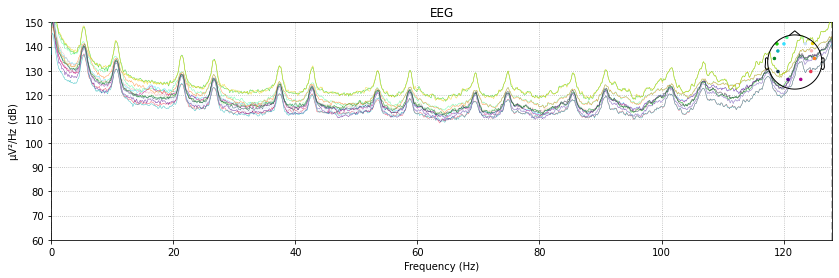

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 48.75 Hz)
- Upper passband edge: 51.00 Hz
- Upper transition bandwi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

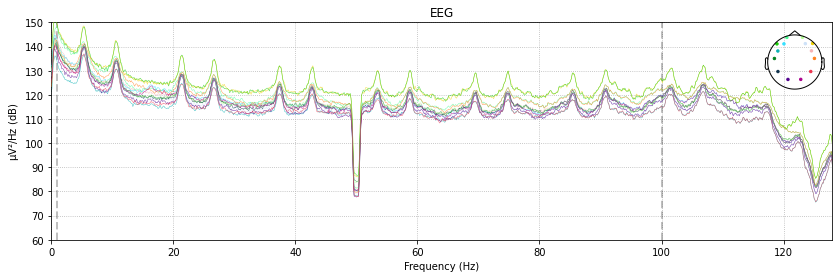

In [7]:
# plotting unfiltered data

fig, ax1 = plt.subplots(figsize=(14,4))
plt.ylim(60, 150)
figura = MNE_to_process.plot_psd(fmax=128,ax=ax1)
# figura.savefig('unfilt', bbox_inches='tight', dpi=300)

lower_bound = 1
upper_bound  = 100

# band pass filtering
MNE_filt = MNE_to_process.copy().filter(lower_bound, upper_bound)

# removing power line with notch filter
power_line_freq = (50)
MNE_filt = MNE_filt.notch_filter(freqs=power_line_freq, notch_widths=1)

# plotting filtered data

fig, ax1 = plt.subplots(figsize=(14,4))
plt.ylim(60, 150)
figura = MNE_filt.plot_psd(fmax=128,ax=ax1)
# figura.savefig('filt', bbox_inches='tight', dpi=300)

## 2.4. ICA

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 14 components
Fitting ICA took 2.0s.
Creating RawArray with float64 data, n_channels=14, n_times=294912
    Range : 0 ... 294911 =      0.000 ...  1151.996 secs
Ready.
Using matplotlib as 2D backend.


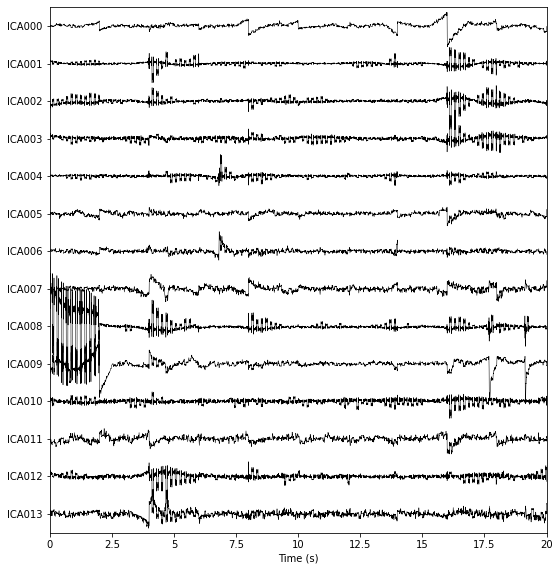

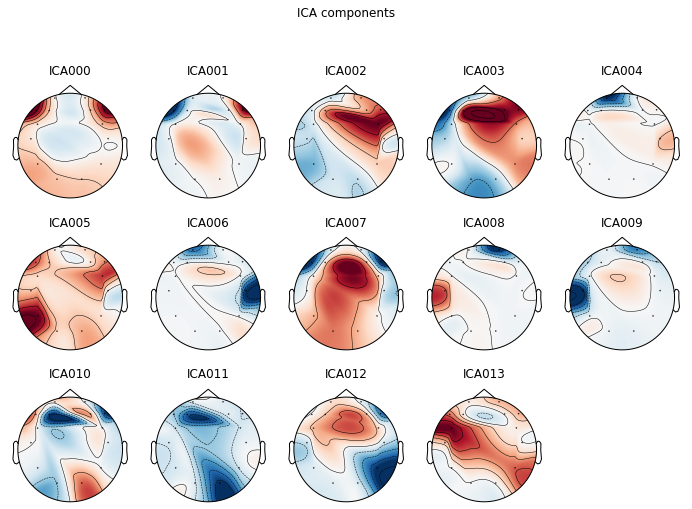

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
576 matching events found
No baseline correction applied
0 pro

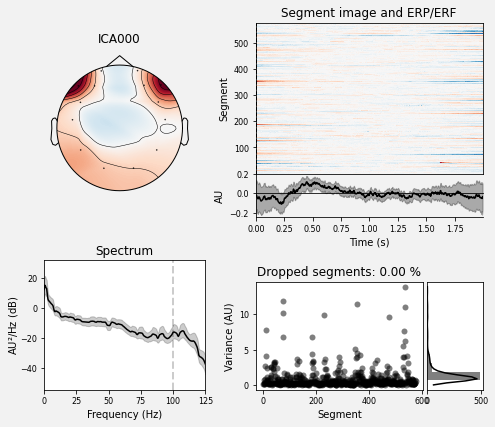

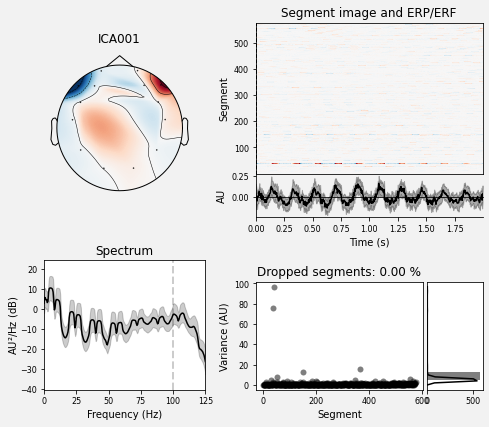

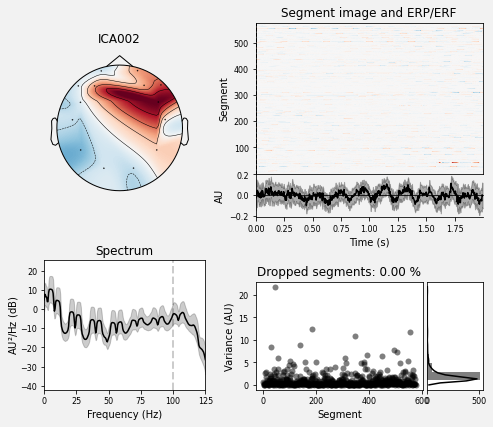

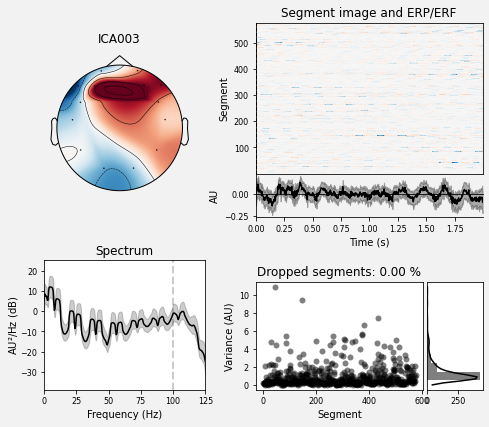

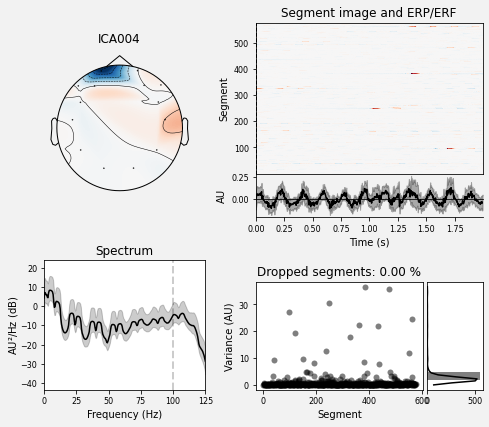

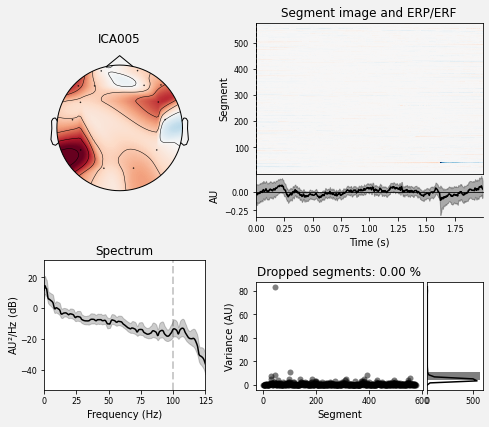

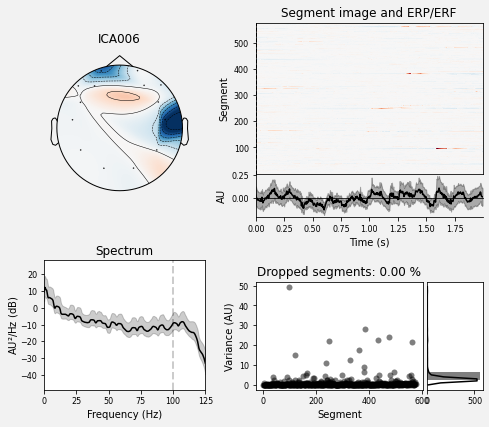

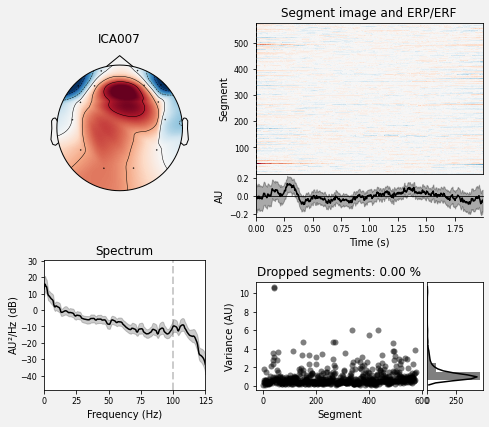

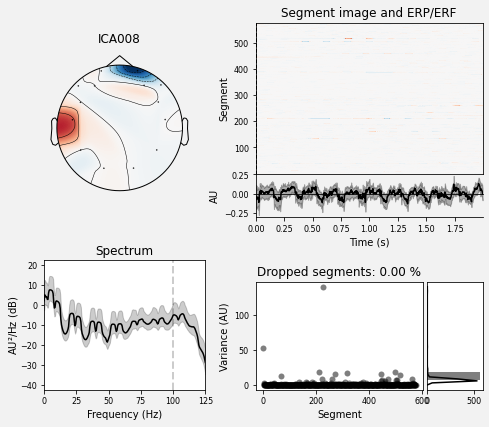

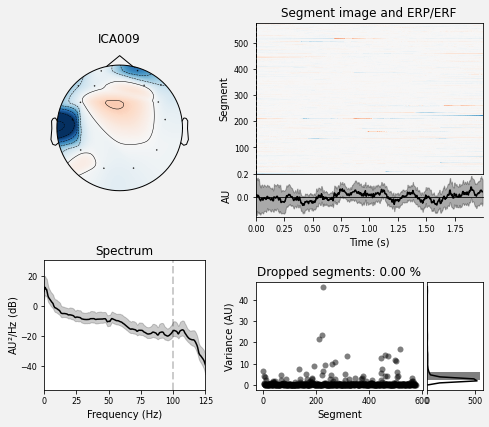

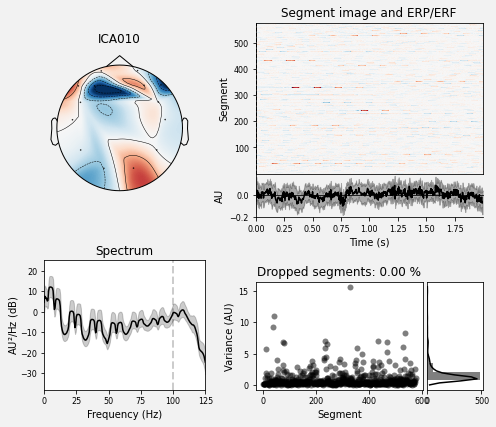

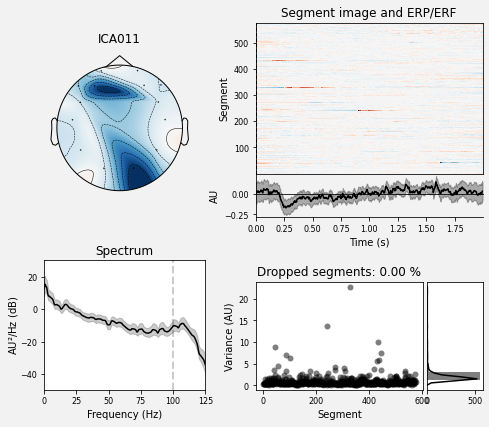

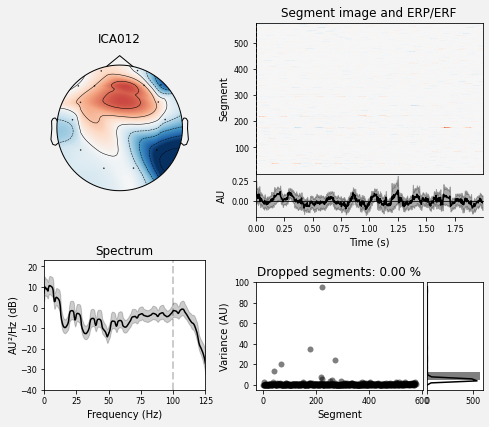

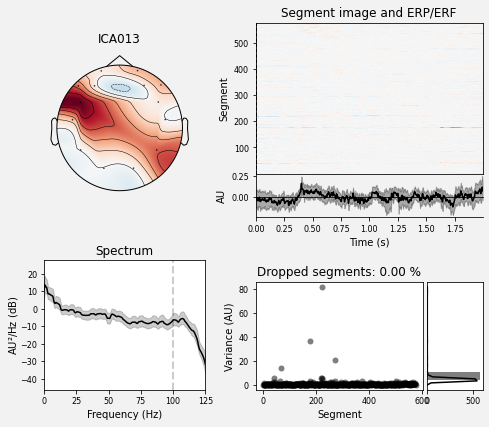

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [8]:
ica_data = MNE_filt.copy()

ICA = mne.preprocessing.ICA(random_state=32)
ICA.fit(ica_data)

ICA.plot_sources(ica_data, show_scrollbars=False)
ICA.plot_components()
ICA.plot_properties(ica_data, picks=[i for i in range(14)])

By visual inspection of ICA sources and associated power spectra we identify artifacts in the following sources and exclude them.

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=294912
    Range : 0 ... 294911 =      0.000 ...  1151.996 secs
Ready.


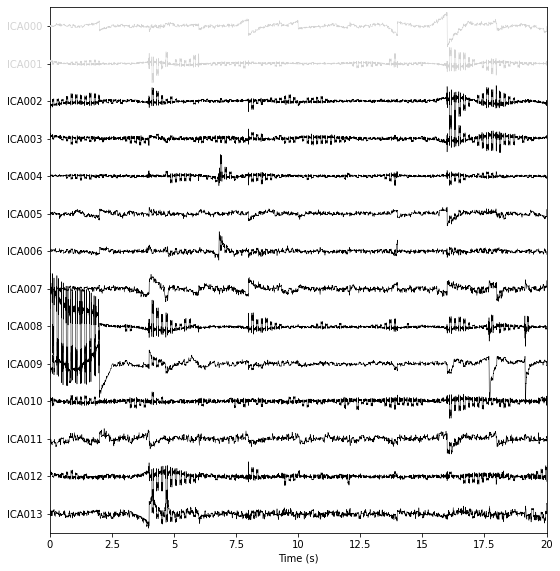

Figure(576x576)


In [9]:
if participant == '1':
    ICA.exclude = []
if participant == '2':
    ICA.exclude = [1,2,3]
#     ICA.plot_overlay(MNE_filt, exclude=[1,2,3])
if participant == '3':
    ICA.exclude = [0,5,10]
if participant == '4':
    ICA.exclude = [0,6]
if participant == '5':
    ICA.exclude = [4,5,9]
if participant == '6':
    ICA.exclude = [8]
if participant == '7':
    ICA.exclude = [3,5]
if participant == '8':
    ICA.exclude = [0,1]
if participant == '9':
    ICA.exclude = [0,1,2]


ICA.apply(ica_data)
print(ICA.plot_sources(MNE_filt, show_scrollbars=False))

# 3. Data visualization

## 3.1. Frozen values

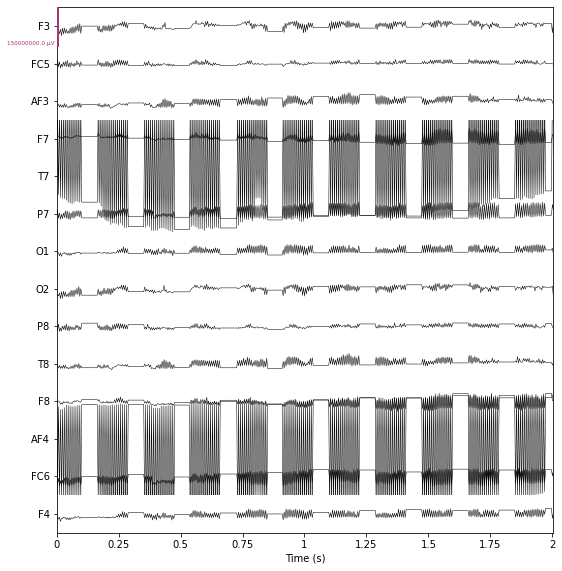

Figure(576x576)


In [10]:
# visualize the data for one epoch, note how many frozen values there are

print(MNE_to_process.plot(n_channels=14,
         show_scrollbars=False, scalings=75, duration = 2))

## 3.2. Plotting evoked responses

### 3.2.1. Words

In [11]:
labels_events = mne.make_fixed_length_events(ica_data, duration=2)

labels_id = {'Ambulance' : 1,'Clock' : 2, 'Hospital' : 3, 'Lamp' : 4}
labels_epoch = np.array(labels)[:,0]

ambulance_events = labels_epoch == 'Ambulance'
clock_events = labels_epoch == 'Clock'
hospital_events = labels_epoch == 'Hospital'
lamp_events = labels_epoch == 'Lamp'

labels_events[ambulance_events, 2] = np.full((n_datapoints_per_class*3,), 1)
labels_events[clock_events, 2] = np.full((n_datapoints_per_class*3,), 2)
labels_events[hospital_events, 2] = np.full((n_datapoints_per_class*3,), 3)
labels_events[lamp_events, 2] = np.full((n_datapoints_per_class*3,), 4)

epoched_lab_data = mne.Epochs(MNE_to_process, tmin = 0, tmax = 2, \
                          baseline=(0, 0), events = labels_events, event_id=labels_id)

# apply projectors after epoching data
epoched_lab_data.apply_proj()

Not setting metadata
576 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


Number of events,576
Events,Ambulance: 144Clock: 144Hospital: 144Lamp: 144
Time range,0.000 – 2.000 sec
Baseline,0.000 – 0.000 sec


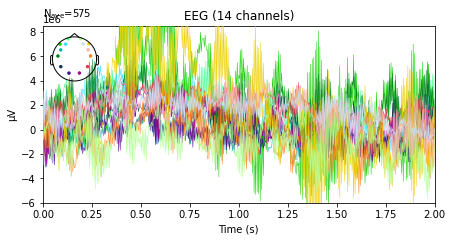

Figure(460.8x216)
No projector specified for this dataset. Please consider the method self.add_proj.


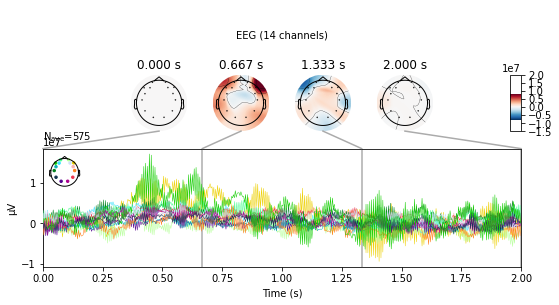

Figure(576x302.4)
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


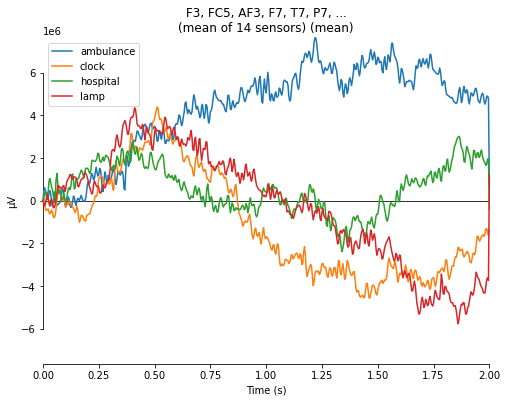

[<Figure size 576x432 with 1 Axes>]


In [12]:
# plot average of all epoched data across dataset
epoched_avg = epoched_lab_data.average()
print(epoched_avg.plot(spatial_colors=True,ylim = dict(eeg=[-6*10e5, 8.5*10e5])))
print(epoched_avg.plot_joint(times='auto'))


# plot evoked responses for the 4 word prompts
epoched_ambulance = epoched_lab_data['Ambulance'].average()
epoched_clock = epoched_lab_data['Clock'].average()
epoched_hospital = epoched_lab_data['Hospital'].average()
epoched_lamp = epoched_lab_data['Lamp'].average()

evoked_labels = dict(ambulance = epoched_ambulance, clock = epoched_clock, \
                     hospital = epoched_hospital, lamp = epoched_lamp)
print(mne.viz.plot_compare_evokeds(evoked_labels, channels, combine='mean'))

### 3.2.2. Stimulus modality

Not setting metadata
576 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


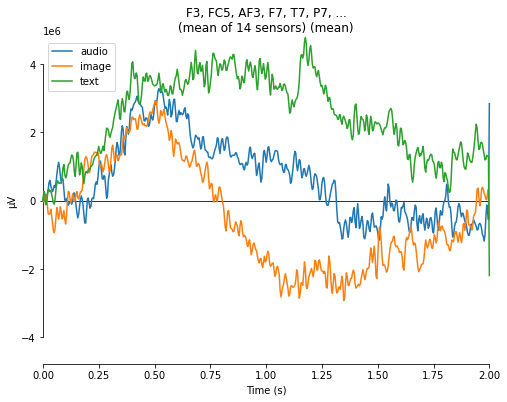

[<Figure size 576x432 with 1 Axes>]


In [13]:
modalities_events = mne.make_fixed_length_events(ica_data, duration=2)

modes_id = {'audio' : 1,'image' : 2, 'text' : 3}
stims_epoch = np.array(stims)[:,0]

audio_events = stims_epoch == 'audio'
image_events = stims_epoch == 'image'
text_events = stims_epoch == 'text'

modalities_events[audio_events, 2] = np.full((n_datapoints_per_class*4,), 1)
modalities_events[image_events, 2] = np.full((n_datapoints_per_class*4,), 2)
modalities_events[text_events, 2] = np.full((n_datapoints_per_class*4,), 3)

epoched_mod_data = mne.Epochs(MNE_to_process, tmin = 0, tmax = 2, \
                          baseline=(0, 0), events = modalities_events, event_id=modes_id)

# apply projectors after epoching data
epoched_mod_data.apply_proj()

# plot evoked responses for audio, image and text stimulus modalities
epoched_audio = epoched_mod_data['audio'].average()
epoched_image = epoched_mod_data['image'].average()
epoched_text = epoched_mod_data['text'].average()

evoked_modalities = dict(audio=epoched_audio, image=epoched_image, text=epoched_text)
print(mne.viz.plot_compare_evokeds(evoked_modalities, channels, combine='mean'))

### 3.2.3. Complexity

Not setting metadata
576 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


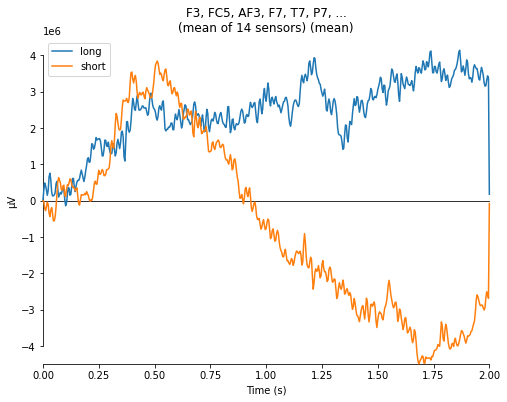

[<Figure size 576x432 with 1 Axes>]


In [14]:
comp_events = mne.make_fixed_length_events(ica_data, duration=2)

comp_id = {'long' : 1,'short' : 2}
comp_epoch = np.array(labels)[:,0]

long_events = ambulance_events + hospital_events
short_events = clock_events + lamp_events

comp_events[long_events, 2] = np.full((n_datapoints_per_class*6,), 1)
comp_events[short_events, 2] = np.full((n_datapoints_per_class*6,), 2)

epoched_comp_data = mne.Epochs(MNE_to_process, tmin = 0, tmax = 2, \
                          baseline=(0, 0), events = comp_events, event_id=comp_id)

# apply projectors after epoching data
epoched_comp_data.apply_proj()

# plot evoked responses for audio, image and text stimulus modalities
epoched_short = epoched_comp_data['short'].average()
epoched_long = epoched_comp_data['long'].average()

evoked_comps = dict(long = epoched_long, short = epoched_short)
print(mne.viz.plot_compare_evokeds(evoked_comps, channels, combine='mean'))

### 3.2.4. Repetition interval

In [15]:
# This works effectively only for participant 2 as it is hardcoded to work by 
# switching events in first and last events (3,10) to make them meet the number of events 
# found by make_fixed_length_events. The issue arises from the fact that in ICA we discard unsuitable
# epochs which causes the number of repetitions data for each stage to become unequal.



# reps_events = mne.make_fixed_length_events(ica_data, duration=2)

# reps_id = {'1-5' : 1,'6-10' : 2}
# reps_epoch = np.array(num_rep)[:,0]


# event1 = reps_epoch == 'speaking1'
# event2 = reps_epoch == 'speaking2' 
# event3 = reps_epoch == 'speaking3'
# event4 = reps_epoch == 'speaking4'
# event5 = reps_epoch == 'speaking5'
# event6 = reps_epoch == 'speaking6'
# event7 = reps_epoch == 'speaking7'
# event8 = reps_epoch == 'speaking8'
# event9 = reps_epoch == 'speaking9'
# event10 = reps_epoch == 'speaking10'

# first_events = event10 + event1 + event2 + event4 + event5
# last_events = event6 + event7 + event8 + event9 + event3
# first_events.sum()

# reps_events[first_events, 2] = np.full((n_datapoints_per_class*6,), 1)
# reps_events[last_events, 2] = np.full((n_datapoints_per_class*6,), 2)

# epoched_reps_data = mne.Epochs(MNE_to_process, tmin = 0, tmax = 2, \
#                           baseline=(0, 0), events = reps_events, event_id=reps_id)

# # apply projectors after epoching data
# epoched_reps_data.apply_proj()

# # plot evoked responses for first and last five repetitions
# epoched_first = epoched_reps_data['1-5'].average()
# epoched_last = epoched_reps_data['6-10'].average()

# evoked_reps = dict(first_five_repetitions = epoched_first, last_five_repetitions = epoched_last)
# print(mne.viz.plot_compare_evokeds(evoked_reps, channels, combine='mean'))

# 4. Data preparation

Prepare data by dividing it into relevant subsets for the investigation of machine learning accuracy for different classification tasks.

In [16]:
df = pd.DataFrame(ica_data.to_data_frame().drop(columns = ['time']\
                                    ).to_numpy().reshape(df_to_process.shape[0] // (epoch_len), epoch_len *14))

df["mode"] = np.array(stims)
df["Label"] = np.array(labels)
df['num_rep'] = np.array(num_rep)

## 4.1.  4-class classification

In [17]:
df_whole = df.copy()

features_whole = df_whole.drop(columns = ['mode', 'Label','num_rep']).to_numpy()
labels_whole = df_whole['Label'].to_numpy()
# np.sum(np.isnan(labels_whole))
# df_whole['Label'].unique()

## 4.2. 4-class classification by stimulus modality

In [18]:
df_audio = df.copy()
df_audio = df_audio[df_audio['mode'] == 'audio']

df_image = df.copy()
df_image = df_image[df_image['mode'] == 'image']

df_text = df.copy()
df_text = df_text[df_text['mode'] == 'text']

features_audio = df_audio.drop(columns = ['mode','Label','num_rep']).to_numpy()
features_text = df_image.drop(columns = ['mode','Label','num_rep']).to_numpy()
features_image = df_text.drop(columns = ['mode','Label','num_rep']).to_numpy()

labels_audio = df_audio.Label.to_numpy()
labels_text = df_text.Label.to_numpy()
labels_image = df_image.Label.to_numpy()

## 4.3. Binary classification by complexity: discerning Long and Short words

In [19]:
df_ls = df.copy()
df_ls['Length'] = 0
df_ls.loc[df_ls['Label'] == 'Lamp', 'Length'] = 'Short'
df_ls.loc[df_ls['Label'] == 'Clock', 'Length'] = 'Short'
df_ls.loc[df_ls['Length'] == 0, 'Length'] = 'Long'
df_ls = df_ls[df_ls.Label != 'Rest']

features_ls = df_ls.drop(columns = ['mode', 'Label','Length','num_rep']).to_numpy()
labels_ls = df_ls['Length'].to_numpy()

## 4.4. Binary classification by complexity: Ambulance vs Hospital and Clock vs Lamp

In [20]:
df_ah = df.copy()
df_cl = df.copy()

df_ah = df_ah[(df_ah['Label'] == 'Ambulance') | (df_ah['Label'] == 'Hospital')]
df_cl = df_cl[(df_cl['Label'] == 'Clock') | (df_cl['Label'] == 'Lamp')]


features_ah = df_ah.drop(columns = ['mode', 'Label','num_rep']).to_numpy()
labels_ah = df_ah['Label'].to_numpy()
features_cl = df_cl.drop(columns = ['mode', 'Label','num_rep']).to_numpy()
labels_cl = df_cl['Label'].to_numpy()

## 4.5. 4-class classification by word repetition number

Three groups: first five (1-5), middle five (3-5) and last five (6-10) repetition intervals in each trial

In [21]:
df5 = df.copy()
df7 = df.copy()
df10 = df.copy()



df5 = df5[(df5['num_rep'] == 'speaking1') | (df5['num_rep'] == 'speaking2') | (df5['num_rep'] == 'speaking3')\
          | (df5['num_rep'] == 'speaking4') | (df5['num_rep'] == 'speaking5')]
df5 = df5[(df5['Label'] != 'Rest')]



df7 = df7[(df7['num_rep'] == 'speaking3') | (df7['num_rep'] == 'speaking4') | (df7['num_rep'] == 'speaking5')\
          | (df7['num_rep'] == 'speaking6') | (df7['num_rep'] == 'speaking7')]
df7 = df7[(df7['Label'] != 'Rest')]



df10 = df10[(df10['num_rep'] == 'speaking6') | (df10['num_rep'] == 'speaking7') |\
            (df10['num_rep'] == 'speaking8') | (df10['num_rep'] == 'speaking9') |\
            (df10['num_rep'] == 'speaking10')]
df10 = df10[(df10['Label'] != 'Rest')]

features5 = df5.drop(columns = ['mode', 'Label','num_rep']).to_numpy()
labels5 = df5['Label'].to_numpy()
features7 = df7.drop(columns = ['mode', 'Label','num_rep']).to_numpy()
labels7 = df7['Label'].to_numpy()
features10 = df10.drop(columns = ['mode', 'Label','num_rep']).to_numpy()
labels10 = df10['Label'].to_numpy()

# 5. Machine learning

In [22]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import VarianceThreshold   

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
                                
from sklearn.multioutput import MultiOutputClassifier

## 5.1.  4-class classification

In [23]:
modelRF = RandomForestClassifier(random_state = 32)
modelSVM = SVC(random_state = 32)
modelKNN = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=32)


X = features_whole
y = labels_whole

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)


scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('RF Accuracy for general 4-class: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))
print(participant)
scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM Accuracy for general 4-class: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('KNN Accuracy for general 4-class: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))

RF Accuracy for general 4-class: 0.271 (0.049)
8
SVM Accuracy for general 4-class: 0.241 (0.040)
KNN Accuracy for general 4-class: 0.259 (0.053)


## 5.2. 4-class classification by stimulus modality

In [24]:
modelRF = RandomForestClassifier(random_state = 32)
modelSVM = SVC(random_state = 32)
modelKNN = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=32)


X = features_audio
y = labels_audio

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)

scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('"RF Accuracy for AUDIO 4 class: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('"SVM Accuracy for AUDIO 4 class: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('"KNN Accuracy for AUDIO 4 class: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))


print('')

X = features_image
y = labels_image
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=32, shuffle = False)

scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('"RF Accuracy for IMAGE 4 class: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('"SVM Accuracy for IMAGE 4 class: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('"KNN Accuracy for IMAGE 4 class: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))


print('')

X = features_text
y = labels_text
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)

scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('RF Accuracy for TEXT 4 class: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM Accuracy for TEXT 4 class: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('KNN Accuracy for TEXT 4 class: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))

"RF Accuracy for AUDIO 4 class: 0.307 (0.105)
"SVM Accuracy for AUDIO 4 class: 0.314 (0.112)
"KNN Accuracy for AUDIO 4 class: 0.236 (0.086)

"RF Accuracy for IMAGE 4 class: 0.234 (0.089)
"SVM Accuracy for IMAGE 4 class: 0.233 (0.062)
"KNN Accuracy for IMAGE 4 class: 0.294 (0.107)

RF Accuracy for TEXT 4 class: 0.239 (0.071)
SVM Accuracy for TEXT 4 class: 0.267 (0.078)
KNN Accuracy for TEXT 4 class: 0.232 (0.113)


## 5.3. Binary classification by complexity: discerning Long and Short words

In [25]:
# modelRF = RandomForestClassifier(random_state = 32)
# modelSVM = SVC(random_state = 32)
# modelKNN = KNeighborsClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=32)


# X = features_ls
# y = labels_ls

# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)

# scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('RF Accuracy for binary Long-Short: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

# scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('SVM Accuracy for binary Long-Short: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

# scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('KNN Accuracy for binary Long-Short: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))

## 5.4. Binary classification by complexity: Ambulance vs Hospital and Clock vs Lamp

In [26]:
# modelRF = RandomForestClassifier(random_state = 32)
# modelSVM = SVC(random_state = 32)
# modelKNN = KNeighborsClassifier()

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=32)



# X = features_ah
# y = labels_ah
# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)

# scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('RF Accuracy for binary Ambulance-Hospital: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

# scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('SVM Accuracy for binary Ambulance-Hospital: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

# scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('KNN Accuracy for binary Ambulance-Hospital: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))


# print('')


# X = features_cl
# y = labels_cl
# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)

# scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('RF Accuracy for binary Clock-Lamp: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

# scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('SVM Accuracy for binary Clock-Lamp: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

# scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('KNN Accuracy for binary Clock-Lamp: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))

## 5.5. 4-class classification by word repetition number

In [27]:
modelRF = RandomForestClassifier(random_state = 32)
modelSVM = SVC(random_state = 32)
modelKNN = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=32)



X = features5
y = labels5
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)

scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('RF Accuracy for 4-class 1-5 repetitions data: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM Accuracy for 4-class 1-5 repetitions data: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('KNN Accuracy for 4-class 1-5 repetitions data: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))


print('')

X = features7
y = labels7
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)

scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('RF Accuracy for 4-class 3-7 repetitions data: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM Accuracy for 4-class 3-7 repetitions data: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('KNN Accuracy for 4-class 3-7 repetitions data: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))


print('')


X = features10
y = labels10
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 32, shuffle = False)

scoresRF = cross_val_score(modelRF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('RF Accuracy for 4-class 6-10 repetitions data: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

scoresSVM = cross_val_score(modelSVM, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM Accuracy for 4-class 6-10 repetitions data: %.3f (%.3f)' % (mean(scoresSVM), std(scoresSVM)))

scoresKNN = cross_val_score(modelKNN, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('KNN Accuracy for 4-class 6-10 repetitions data: %.3f (%.3f)' % (mean(scoresKNN), std(scoresKNN)))

RF Accuracy for 4-class 1-5 repetitions data: 0.268 (0.078)
SVM Accuracy for 4-class 1-5 repetitions data: 0.277 (0.072)
KNN Accuracy for 4-class 1-5 repetitions data: 0.239 (0.086)

RF Accuracy for 4-class 3-7 repetitions data: 0.247 (0.065)
SVM Accuracy for 4-class 3-7 repetitions data: 0.254 (0.060)
KNN Accuracy for 4-class 3-7 repetitions data: 0.273 (0.094)

RF Accuracy for 4-class 6-10 repetitions data: 0.244 (0.075)
SVM Accuracy for 4-class 6-10 repetitions data: 0.315 (0.062)
KNN Accuracy for 4-class 6-10 repetitions data: 0.234 (0.087)


## 5.6. Optimization: feature extraction and hyperparameter tuning

Feature extraction and hyperparameter tuning pipeline for 4-class classification

In [28]:
# pipeline = Pipeline([
# ('scaler', StandardScaler()),
# ('classifier', RandomForestClassifier(random_state=32)),
# #     ('classifier', SVC(random_state=32))
# ])

# params = {'scaler': [StandardScaler(), MinMaxScaler()]
# #     ,'classifier__n_estimators': [100, 500],
# #     'classifier__max_features': [4,6],
# #     'classifier__max_depth' : [4,6,8],
# }

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=32)

# grid_search = GridSearchCV(pipe, parameters, cv=5,refit=True)
# choice = search.fit(X_train, y_train)

# optimal_params = choice.best_params_
# optimal_pipeline = choice.best_estimator_
# optimal_acc_std = (choice.score(X_test, y_test),choice.cv_results_['std_test_score'][choice.best_index_])
# # print('Mean, Std:', optimal_acc_std)
# # print('Best Pipeline', optimal_pipeline)
# best_score

# # y_pred = choice.predict(X_test)
# # cm = confusion_matrix(y_test, y_pred)
# # print(classification_report(y_test,y_pred))